In [1]:
from PIL import ImageFont, ImageDraw, Image
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import label
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
import os

In [10]:
data_path = '/data/steeve/mandarin/frames/'
frame_list = glob.glob(f'{data_path}/*')

In [11]:
import os

In [12]:
font_list =  os.listdir('/usr/share/fonts/truetype/')
font_list = [f for f in font_list if '.ttf' in f] 
font_list

['yahei.ttf', 'wt024.ttf', 'BKT.ttf', 'rouhei.ttf']

In [13]:
def get_multi_masks(img):
#     label = img.copy()
#     label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
#     print(img.shape)
#     thresh = threshold_otsu(img)
    _, thresh = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)
#     bw = closing(img > thresh, square(3))

    # remove artifacts connected to image border
#     cleared = bw.copy()
#     clear_border(cleared)

    # label image regions
#     label_image = label(cleared)
#     bw = closing(image > thresh)
    return label(thresh)

In [14]:
def multi_mask_to_color_overlay(multi_mask, image=None, color=None):

    height,width = multi_mask.shape[:2]
    overlay = np.zeros((height,width,3),np.uint8) if image is None else image.copy()
    num_masks = int(multi_mask.max())
    if num_masks==0: return overlay

    if type(color) in [str] or color is None:
        #https://matplotlib.org/xkcd/examples/color/colormaps_reference.html

        if color is None: color='summer'  #'cool' #'brg'
        color = plt.get_cmap(color)(np.arange(0,1,1/num_masks))
        color = np.array(color[:,:3])*255
        color = np.fliplr(color)
        #np.random.shuffle(color)

    elif type(color) in [list,tuple]:
        color = [ color for i in range(num_masks) ]

    for i in range(num_masks):
        mask = multi_mask==i+1
        overlay[mask]=color[i]
        #overlay = instance[:,:,np.newaxis]*np.array( color[i] ) +  (1-instance[:,:,np.newaxis])*overlay

    return overlay

In [15]:
def generate(file_name, text, font_type, text_location = 0.84 , draw_number=1, font_size = 22):
    im = cv2.imread(file_name)
    y, x,_ = im.shape
    im = im[:int((0.6)*y),:,:]
    firstcrop_y, firstcrop_x,_ = im.shape
    cv2_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # cv2和PIL中颜色的hex码的储存顺序不同

    pil_im = Image.fromarray(np.zeros([firstcrop_y, firstcrop_x,3]).astype('uint8'))
    draw = ImageDraw.Draw(pil_im) # 括号中为需要打印的canvas，这里就是在图片上直接打印

    font = ImageFont.truetype(font_type, font_size, encoding="utf-8")
    
    x, y = pil_im.width, pil_im.height
    x /=2
    y = text_location * y
    shadowcolor = (0, 0, 0)

    text_width, text_height = font.getsize(text)
    x = x-text_width /2
    for i in range(draw_number):
        draw.text((x-1, y), text, font=font, fill=shadowcolor)
        draw.text((x+1, y), text, font=font, fill=shadowcolor)
        draw.text((x, y-1), text, font=font, fill=shadowcolor)
        draw.text((x, y+1), text, font=font, fill=shadowcolor)
    
    draw.text((x, y), text, (255, 255, 255), font=font)
    pil_im = cv2.cvtColor(np.array(pil_im), cv2.COLOR_BGR2GRAY)
    multi_masks = get_multi_masks(np.array(pil_im))
   
    
    sample = Image.fromarray(cv2_im)

    draw = ImageDraw.Draw(sample) 
    font = ImageFont.truetype(font_type, font_size, encoding="utf-8")
    x, y = sample.width, sample.height
    x /=2
    y = text_location * y
    x = x-text_width /2
    for i in range(draw_number):
        draw.text((x-1, y), text, font=font, fill=shadowcolor)
        draw.text((x+1, y), text, font=font, fill=shadowcolor)
        draw.text((x, y-1), text, font=font, fill=shadowcolor)
        draw.text((x, y+1), text, font=font, fill=shadowcolor)
    draw.text((x, y), text, (255, 255, 255), font=font)
    sample = np.array(sample)
    image_label_overlay = multi_mask_to_color_overlay(multi_masks, image=sample)
    
    return sample, multi_masks, image_label_overlay

In [16]:
def get_input_text():
    with open('input/meng_zi_processed.txt', 'rb') as f:
        texts = [t.decode('utf-8').strip() for t in f.readlines()]
    
    with open('input/lunyu_processed.txt', 'rb') as f:
        texts += [t.decode('utf-8').strip() for t in f.readlines()]
        
    with open('input/liangshiqiu_processed.txt', 'rb') as f:
        texts += [t.decode('utf-8').strip() for t in f.readlines()]
    return texts

In [17]:
all_texts = get_input_text()
len(all_texts)

6941

In [18]:
sampled_images = np.random.choice(glob.glob('/data/steeve/mandarin/frames/*'), size=len(all_texts))
sampled_fonts = np.random.choice(font_list, size=len(all_texts))
text_locations = np.random.uniform(low=0.7, high=0.84, size=len(all_texts))
font_sizes = np.random.choice(np.arange(20,26), size=len(all_texts))
draw_numbers = np.random.choice(np.arange(1, 10), size= len(all_texts))

In [19]:
def file_name_to_id(file_name):
    return file_name.split('/')[-1].split('.png')[0]

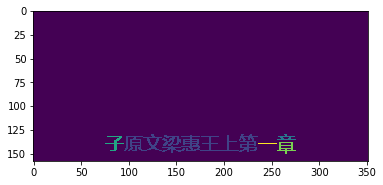

In [21]:
for index, text in enumerate(all_texts):
    fn = sampled_images[index]
    ft = sampled_fonts[index]
    tl = text_locations[index]
    fs = font_sizes[index]
    dn = draw_numbers[index]
    id_ = file_name_to_id(fn)
    image, multi_masks, overlay = generate(fn, text, ft, tl , dn, fs)
    plt.imshow(multi_masks)
    
    break
#     np.save(f'/data/steeve/mask_rcnn/multi_masks/{id_}.npy', multi_masks)
#     cv2.imwrite(f'/data/steeve/mask_rcnn/multi_masks/{id_}.png', multi_masks)
#     cv2.imwrite(f'/data/steeve/mask_rcnn/overlays/{id_}.png', overlay)
#     cv2.imwrite(f'/data/steeve/mask_rcnn/images/{id_}.png', image)

# Check if generated files are Okay

In [2]:
data_dir = '/data/steeve/mask_rcnn/'

In [3]:
ids = os.listdir(data_dir + 'images')
ids = [i.split('.png')[0] for i in ids ]
ids

['mFbR0qh_5MM-0000080-0.25',
 'Ex_xYaPrsVc-0000164-0.25',
 'Twl-p1k1Pkg-0000198-0.25',
 '1NC6adzdwUs-0000157-0.25',
 'P9IKbWsJjN4-0000350-0.25',
 'ScQSe67nAeQ-0000194-0.25',
 'wJyKeSHoTzo-0000307-0.25',
 '0uhS1bvw9pA-0000001-0.25',
 'cfhGQ3p1Uvo-0000229-0.25',
 'pyPB0MgPhfY-0000446-0.25',
 'JsudxCQz_2k-0000132-0.25',
 'pMYyWMWluwg-0000562-0.25',
 'ZQ8VJtLsLao-0000326-0.25',
 'mS9zRxHnf7Q-0000441-0.25',
 '1NC6adzdwUs-0000482-0.25',
 'pyPB0MgPhfY-0000288-0.25',
 'GDGk51d4Ync-0000119-0.25',
 'DTfHpK5W4M4-0000283-0.25',
 'pct48YAbHV8-0000272-0.25',
 'k7_ctM5fjrw-0000086-0.25',
 '9bGrxu1kkpk-0000473-0.25',
 'Z2_pIzO7GOk-0000299-0.25',
 'SpjRBoVvAA4-0000018-0.25',
 'TAnrWB6EAc0-0000247-0.25',
 '2F6eiSIQWhE-0000193-0.25',
 'QdrLyL7wH_I-0000341-0.25',
 '1NbYuGHOWNA-0000341-0.25',
 'w9YaeJZRwVo-0000190-0.25',
 'K7aMiVZHr-Q-0000209-0.25',
 'yCyy0YrgVJE-0000246-0.25',
 '5hEenMRX-9w-0000468-0.25',
 '95PKy7moj5U-0000041-0.25',
 'pHvPuQai57Y-0000061-0.25',
 '1EM1aaJfPck-0000385-0.25',
 'pMYyWMWluwg-

11
13
11
10


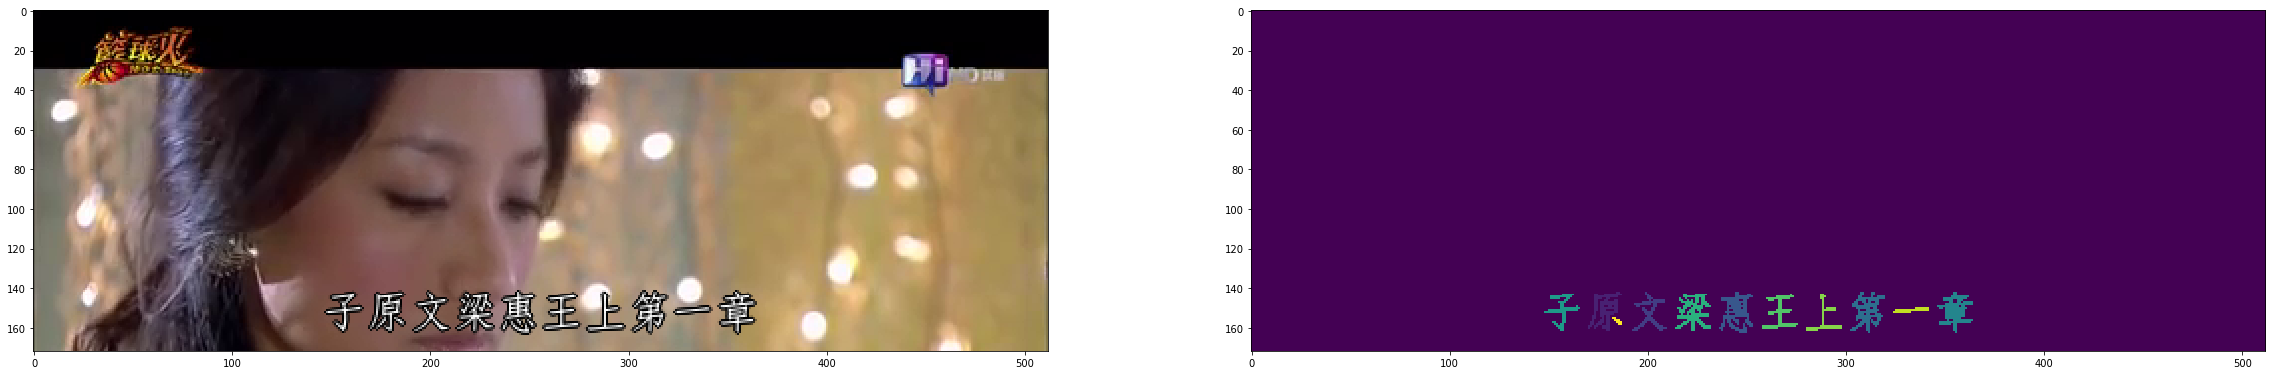

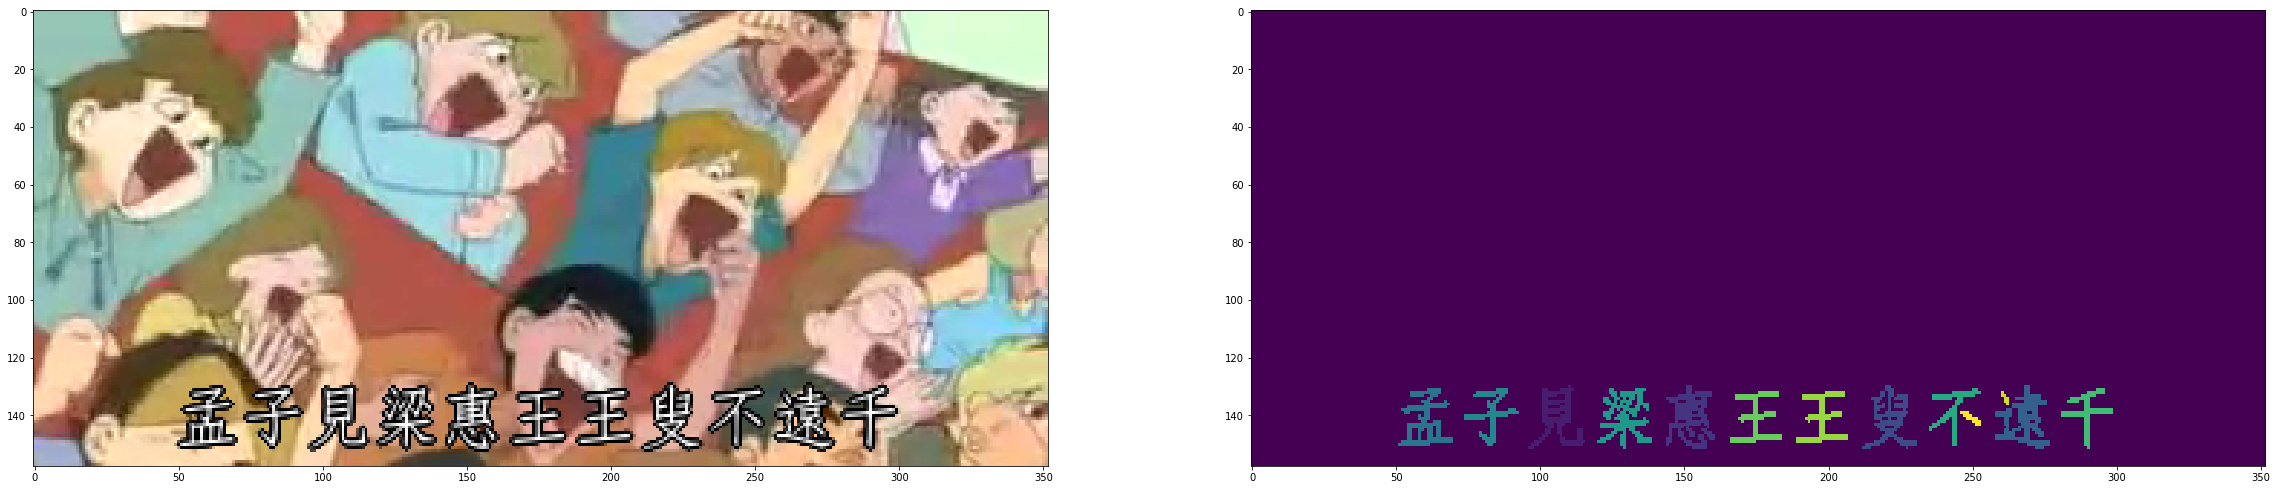

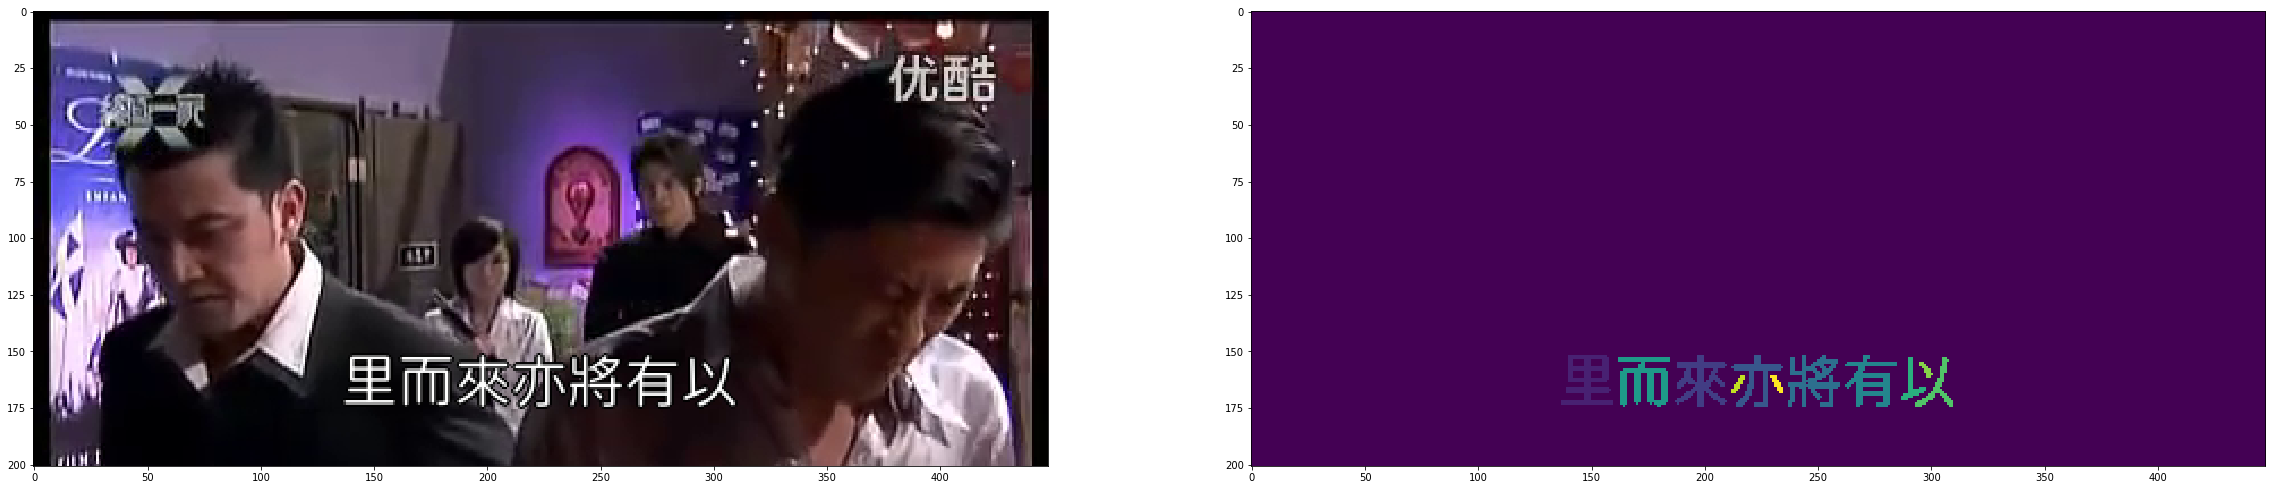

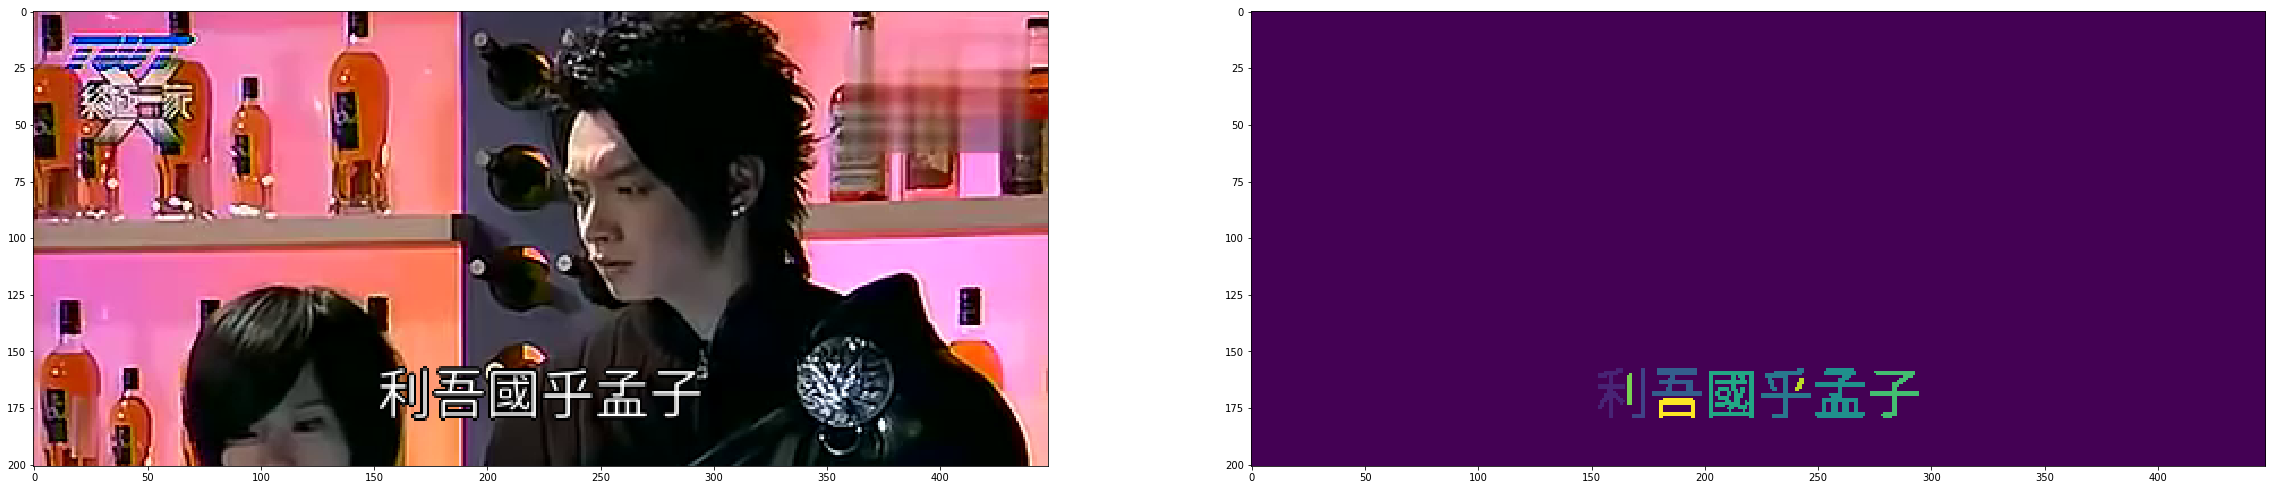

In [8]:
for id_ in ids[:4]:
    image = cv2.imread(data_dir+f'images/{id_}.png')
    overlay = cv2.imread(data_dir + f'overlays/{id_}.png')
    multi_masks = np.load(data_dir + f'multi_masks/{id_}.npy')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40, 40))
#     print(data_dir+'images/{id_}.png')
    print(multi_masks.max())
    ax[0].imshow(image)
#     ax[1].imshow(overlay)
    ax[1].imshow(multi_masks)